In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
def make_windows(ds, hist_size = 3, pred_size=1, pred_col=0):
    test_ds = ds.values
    history_size = hist_size
    prediction_size = pred_size
    pred_col = pred_col
    test_hist = []
    test_pred = []
    for i in range(0,test_ds.shape[0]-history_size-prediction_size+1):
        test_hist.append(test_ds[i:i+history_size])
        test_pred.append(test_ds[i+history_size:i+history_size+prediction_size,pred_col])
    return test_hist,test_pred

In [3]:
#builds the model
def build_model(dropout = 0.1,optimizer = "adam",init_mode = "uniform",lstm1_n = 32, lstm2_n=16,loss = 'mean_absolute_error',activation = "relu"):
    model = Sequential()
    #model.add(GaussianNoise(0.01, input_shape=x_train.shape[-2:]))
    model.add(Bidirectional(LSTM(32,
                return_sequences=True,activation='relu',
                input_shape=x_train.shape[-2:],
                #recurrent_regularizer=tf.keras.regularizers.l2(10**-6
                                )))
    model.add(LSTM(16, activation='relu'))
    model.add(Dense(prediction_size))
    model.compile(optimizer = "adam", loss="mae",metrics=["mse"])
    return model

In [4]:
def sample_window_plot(history, true_future, prediction,past_history,future_target, lim = (0,1)):
  plt.figure(figsize=(12, 6))
  plt.title("One sample of x:history and y:True future")
  num_in = list(range(-len(history),0))
  num_out = len(true_future)
  STEP=1
  plt.plot(num_in, np.array(history[:, 0]), label='History')
  print(history.shape)
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.grid(color='grey', linestyle='-', linewidth=0.5)
  plt.xticks(np.arange(-past_history,future_target, step=1)) 

  plt.show()

In [5]:
file_dir = 'caba.txt'
data = pd.read_csv(file_dir,sep=",",quotechar='"',na_values=[''],header=None)
df = pd.DataFrame(data)

In [6]:
#aniadimos nombres de las columnas
df.columns = ["Fecha","CasosAcc","CasosInc","MuertesAcc","MuertesInc","Pop","DescAcc","ICUAcc","Retail_rec_change",
                    "Grocery_pharmacy_change",
                    "Parks_change",
                    "Transit_change",
                    "Work_change",
                    "House_change",]

In [7]:
pop = df["Pop"][0]
df = df.drop(["Fecha","Pop"],axis=1)

# preliminar, carga de datos

In [8]:
columnas_a_escalear = ["CasosAcc","CasosInc","MuertesAcc","MuertesInc","DescAcc","ICUAcc"]
df[columnas_a_escalear] = (df[columnas_a_escalear]/pop)*100000

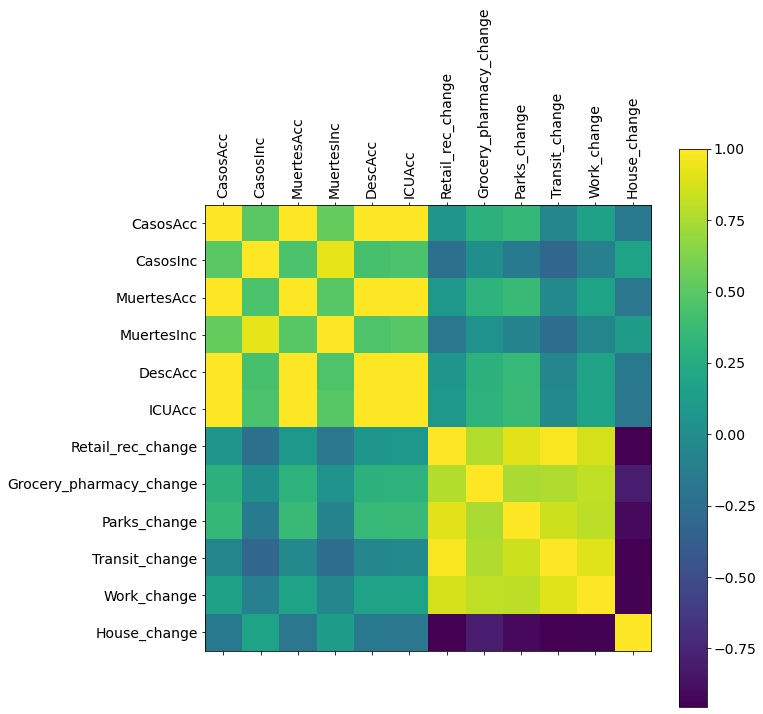

In [9]:
    f = plt.figure(figsize=(10, 10))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #df.head(min(counts)).plot(subplots=True,figsize = (12,15))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

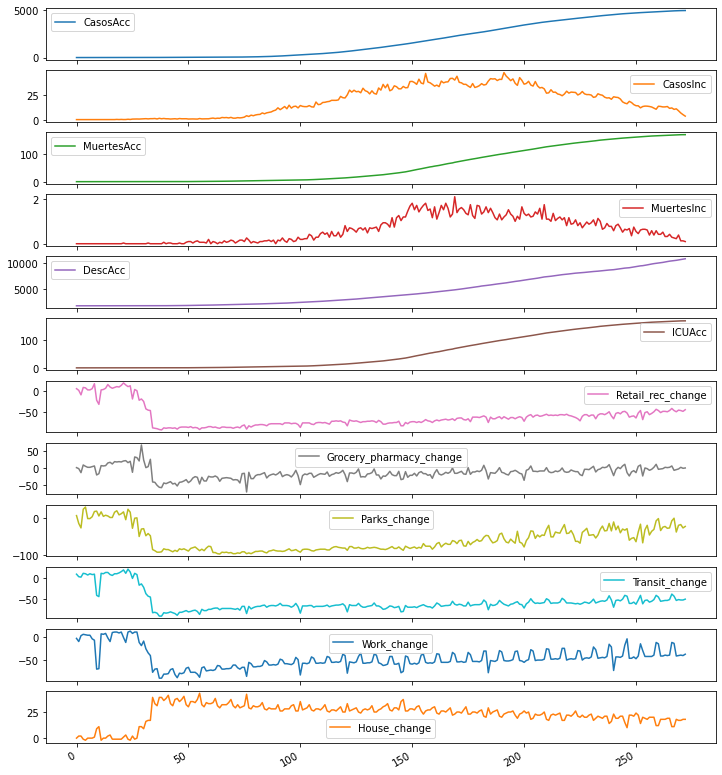

In [10]:
df.head(df.shape[0]).plot(subplots=True,figsize = (12,15))

# normalizacion y etc antes de crear el modelo y etc

In [11]:
history_size = 5
#days to predict
prediction_size = 5
pred_col = 0
#percent to remove for validation
val_percent = .8

In [12]:
all_history = []
all_pred = []
temp_x, temp_y = make_windows(df,history_size,prediction_size,pred_col)
all_history = all_history + temp_x
all_pred = all_pred + temp_y

In [13]:
all_ds = [len(make_windows(df,history_size\
                           ,prediction_size,pred_col)[0]) for x in range(0,1)]
datapoints_size = sum(all_ds)

In [14]:
ds_x = np.array(all_history)
ds_y = np.array(all_pred)
num_val_cases = int(datapoints_size*val_percent)

In [15]:
x_test = ds_x[num_val_cases:]
y_test = ds_y[num_val_cases:]
x_train = ds_x[:num_val_cases]
y_train = ds_y[:num_val_cases]

In [16]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
stacked_x_train=x_train.reshape(len(x_train)*history_size,x_train.shape[2])
stacked_x_test=x_test.reshape(len(x_test)*history_size,x_test.shape[2])
x_scaler.fit(stacked_x_train)
y_scaler.fit(y_train)
stacked_x_train =x_scaler.transform(stacked_x_train)
y_train = y_scaler.transform(y_train)
stacked_x_test = x_scaler.transform(stacked_x_test)
y_test = y_scaler.transform(y_test)
x_train = stacked_x_train.reshape(len(x_train),history_size,x_train.shape[2])
x_test = stacked_x_test.reshape(len(x_test),history_size,x_test.shape[2])

In [17]:
model = build_model()

In [18]:
EPOCHS = 300
batch_size = 32
#note: batch_size is in kfold in  order to perform with same
model = build_model()

In [19]:
modely = model.fit(x_train,y_train,epochs=EPOCHS,\
                                           batch_size = batch_size,validation_data=(x_test,y_test),\
                                           verbose = 2)

Train on 211 samples, validate on 53 samples
Epoch 1/300
211/211 - 3s - loss: 0.3003 - mse: 0.1905 - val_loss: 1.0830 - val_mse: 1.2045
Epoch 2/300
211/211 - 0s - loss: 0.2530 - mse: 0.1518 - val_loss: 0.9841 - val_mse: 1.0258
Epoch 3/300
211/211 - 0s - loss: 0.2165 - mse: 0.1245 - val_loss: 0.8414 - val_mse: 0.8635
Epoch 4/300
211/211 - 0s - loss: 0.1753 - mse: 0.1105 - val_loss: 0.6287 - val_mse: 0.7743
Epoch 5/300
211/211 - 0s - loss: 0.1451 - mse: 0.0947 - val_loss: 0.5858 - val_mse: 0.6145
Epoch 6/300
211/211 - 0s - loss: 0.1203 - mse: 0.0711 - val_loss: 0.4214 - val_mse: 0.4136
Epoch 7/300
211/211 - 0s - loss: 0.0856 - mse: 0.0426 - val_loss: 0.2702 - val_mse: 0.2181
Epoch 8/300
211/211 - 0s - loss: 0.0658 - mse: 0.0243 - val_loss: 0.2417 - val_mse: 0.1382
Epoch 9/300
211/211 - 0s - loss: 0.0539 - mse: 0.0156 - val_loss: 0.2228 - val_mse: 0.1142
Epoch 10/300
211/211 - 0s - loss: 0.0427 - mse: 0.0109 - val_loss: 0.1726 - val_mse: 0.0804
Epoch 11/300
211/211 - 0s - loss: 0.0344 - m

Epoch 86/300
211/211 - 0s - loss: 0.0043 - mse: 4.2825e-05 - val_loss: 0.0613 - val_mse: 0.0059
Epoch 87/300
211/211 - 0s - loss: 0.0036 - mse: 2.8320e-05 - val_loss: 0.0531 - val_mse: 0.0049
Epoch 88/300
211/211 - 0s - loss: 0.0034 - mse: 2.6370e-05 - val_loss: 0.0620 - val_mse: 0.0061
Epoch 89/300
211/211 - 0s - loss: 0.0037 - mse: 3.0903e-05 - val_loss: 0.0640 - val_mse: 0.0063
Epoch 90/300
211/211 - 0s - loss: 0.0033 - mse: 2.4730e-05 - val_loss: 0.0678 - val_mse: 0.0071
Epoch 91/300
211/211 - 0s - loss: 0.0032 - mse: 2.4066e-05 - val_loss: 0.0537 - val_mse: 0.0051
Epoch 92/300
211/211 - 0s - loss: 0.0030 - mse: 1.9717e-05 - val_loss: 0.0827 - val_mse: 0.0100
Epoch 93/300
211/211 - 0s - loss: 0.0030 - mse: 1.9995e-05 - val_loss: 0.0919 - val_mse: 0.0120
Epoch 94/300
211/211 - 0s - loss: 0.0036 - mse: 2.8175e-05 - val_loss: 0.0557 - val_mse: 0.0054
Epoch 95/300
211/211 - 0s - loss: 0.0036 - mse: 2.9995e-05 - val_loss: 0.0590 - val_mse: 0.0059
Epoch 96/300
211/211 - 0s - loss: 0.0036

Epoch 171/300
211/211 - 0s - loss: 0.0028 - mse: 1.4377e-05 - val_loss: 0.0880 - val_mse: 0.0124
Epoch 172/300
211/211 - 0s - loss: 0.0022 - mse: 1.1218e-05 - val_loss: 0.0760 - val_mse: 0.0097
Epoch 173/300
211/211 - 0s - loss: 0.0023 - mse: 1.0876e-05 - val_loss: 0.0733 - val_mse: 0.0093
Epoch 174/300
211/211 - 0s - loss: 0.0031 - mse: 2.1726e-05 - val_loss: 0.1095 - val_mse: 0.0173
Epoch 175/300
211/211 - 0s - loss: 0.0027 - mse: 1.8897e-05 - val_loss: 0.1038 - val_mse: 0.0161
Epoch 176/300
211/211 - 0s - loss: 0.0024 - mse: 1.2091e-05 - val_loss: 0.1105 - val_mse: 0.0179
Epoch 177/300
211/211 - 0s - loss: 0.0033 - mse: 2.2134e-05 - val_loss: 0.0848 - val_mse: 0.0120
Epoch 178/300
211/211 - 0s - loss: 0.0038 - mse: 3.1520e-05 - val_loss: 0.0846 - val_mse: 0.0120
Epoch 179/300
211/211 - 0s - loss: 0.0037 - mse: 3.0494e-05 - val_loss: 0.0793 - val_mse: 0.0108
Epoch 180/300
211/211 - 0s - loss: 0.0030 - mse: 2.0117e-05 - val_loss: 0.1054 - val_mse: 0.0170
Epoch 181/300
211/211 - 0s - l

Epoch 256/300
211/211 - 0s - loss: 0.0022 - mse: 1.3038e-05 - val_loss: 0.0864 - val_mse: 0.0121
Epoch 257/300
211/211 - 0s - loss: 0.0016 - mse: 6.3911e-06 - val_loss: 0.0783 - val_mse: 0.0105
Epoch 258/300
211/211 - 0s - loss: 0.0021 - mse: 1.0424e-05 - val_loss: 0.1032 - val_mse: 0.0159
Epoch 259/300
211/211 - 0s - loss: 0.0024 - mse: 1.0736e-05 - val_loss: 0.0775 - val_mse: 0.0101
Epoch 260/300
211/211 - 0s - loss: 0.0031 - mse: 2.3876e-05 - val_loss: 0.0795 - val_mse: 0.0103
Epoch 261/300
211/211 - 0s - loss: 0.0027 - mse: 1.7345e-05 - val_loss: 0.0809 - val_mse: 0.0106
Epoch 262/300
211/211 - 0s - loss: 0.0028 - mse: 1.9406e-05 - val_loss: 0.0826 - val_mse: 0.0112
Epoch 263/300
211/211 - 0s - loss: 0.0026 - mse: 1.6711e-05 - val_loss: 0.0946 - val_mse: 0.0138
Epoch 264/300
211/211 - 0s - loss: 0.0027 - mse: 1.6452e-05 - val_loss: 0.0796 - val_mse: 0.0109
Epoch 265/300
211/211 - 0s - loss: 0.0034 - mse: 2.9636e-05 - val_loss: 0.0766 - val_mse: 0.0102
Epoch 266/300
211/211 - 0s - l

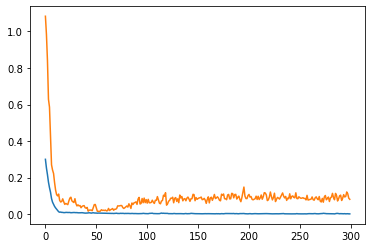

In [20]:
plt.plot(modely.history['loss'],label='train')
plt.plot(modely.history['val_loss'],label='test')

(5, 12)


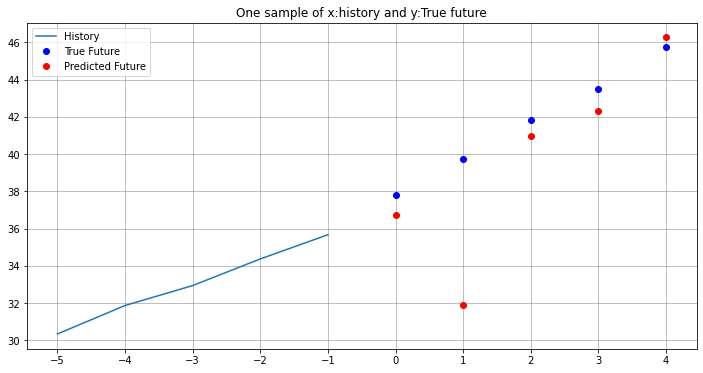

In [23]:
def plot_n_result(n):
    x_temp = x_train[n:n+batch_size,:,:]
    y_temp = y_train[n:n+batch_size,:]
    #y_temp = y_temp.reshape(1,-1)
 
    p_temp = np.array(model.predict(x_train[n:n+batch_size,:,:]))
    x_unscaled = x_scaler.inverse_transform(x_temp[n])
    y_unscaled = y_scaler.inverse_transform(y_temp)
    p_unscaled = y_scaler.inverse_transform(p_temp)

    sample_window_plot(x_unscaled, y_unscaled[n], p_unscaled[n],history_size,prediction_size)
    
plot_n_result(30)